# Helmholtz Equation with Null Infinity Compactification

In [1]:
# Import packages
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
import sympy
from shenfun import *
from scipy.sparse.linalg import spsolve

# Import differentiation matrices
from diff import *

In [99]:
# Explicit equation setup (independent from discretization)

# Parameters
r0=0.5
r1=1.0
k=10

# Coefficient and solution as sympy functions
x = sympy.Symbol('x')
a = 1-x**2
b = 2*x*(1j*k-1)
c = k*(1j+k)
ue= (1+x)**(1j*k)
print(sympy.simplify(a*ue.diff(x,x)+b*ue.diff(x)+c*ue))

# Coefficient and solution as arrays
def ex_tanh(r, k):
    a_arr = sympy.lambdify(x, a, "numpy")(r)
    b_arr = sympy.lambdify(x, b, "numpy")(r)
    c_arr = sympy.lambdify(x, c, "numpy")(r)*np.ones(len(r))
    ue_arr= sympy.lambdify(x, ue,"numpy")(r)
    return a_arr, b_arr, c_arr, ue_arr

0


In [100]:
# Finite Difference
def compute_error_fd(N, r0, r1, k, coefs, order):
    x=np.linspace(r0,r1,N+1,endpoint=True)
    h=(r1-r0)/N
    f = np.zeros(N, dtype=complex)
    a, b, c, u = coefs(x, k)
    u0 = u[0]
    if order=='2':
        D1,D2 = fd_o2(N+1, h)
        f[0] = (- a[1]/h**2 + b[1]/(2*h))*u0
    elif order=='4':
        D1,D2 = fd_o4(N+1, h)
        f[0] = (- 10*a[1]/(12*h**2) + 3*b[1]/(12*h))*u0
        f[1] = (a[2]/(12*h**2) - b[2]/(12*h))*u0
    elif order=='6':
        D1,D2 = fd_o6(N+1, h)
        f[0] = (- 126*a[1]/(180*h**2) + 10*b[1]/(60*h))*u0
        f[1] = (11*a[2]/(180*h**2) - 2*b[2]/(60*h))*u0
        f[2] = (-2*a[3]/(180*h**2) + b[3]/(60*h))*u0
    D1 = D1[1:, 1:]
    D2 = D2[1:, 1:]
    A = sp.diags(a[1:])*D2 + sp.diags(b[1:])*D1 + sp.diags(c[1:])
    nsol = spsolve(A, f)
    return np.linalg.norm(nsol-u[1:])

In [151]:
N=10
iterations = 8
err_o2=[]; err_o4=[]; err_o6=[]
cells=[]
for i in range(iterations):
    cells.append(N)
    err_o2.append(compute_error_fd(N, r0, r1, k, ex_tanh, '2'))
    err_o4.append(compute_error_fd(N, r0, r1, k, ex_tanh, '4'))
    err_o6.append(compute_error_fd(N, r0, r1, k, ex_tanh, '6'))
    N*=2

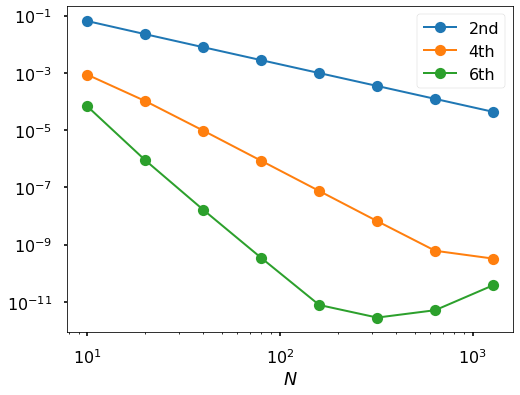

In [152]:
plt.figure(figsize = (8, 6))
plt.xlabel("$N$")
plt.loglog(cells, err_o2, 'o-', lw=2, label='2nd')
plt.loglog(cells, err_o4, 'o-', lw=2, label='4th')
plt.loglog(cells, err_o6, 'o-', lw=2, label='6th')
plt.legend(loc='upper right')

In [109]:
# Chebyshev-Collocation
def compute_error_cc(N, r0, r1, k, coefs):
    D1,D2,x = cheb(N,r0,r1)
    a, b, c, u = coefs(x, k)
    D1 = D1[1:, 1:]
    D2 = D2[1:, 1:]
    f = -c[1:] * u[0]
    A = np.diag(a[1:]).dot(D2) + np.diag(b[1:]).dot(D1) + np.diag(c[1:])
    nsol=np.linalg.solve(A, f)
    return np.linalg.norm(nsol + u0*np.ones(N) - u[1:])

In [164]:
# Spectral-Galerkin
def compute_error_sg(N, r0, r1, k):
    global a, b, c, ue
    u0 = ue.subs(x,r0)
    T = FunctionSpace(N, 'Chebyshev', domain=(r0, r1), dtype='complex', bc=(u0,None))
    u = TrialFunction(T)
    v = TestFunction(T)
    A = inner(v, a*div(grad(u))+b*grad(u)+c*u)
    sol = la.Solver(A)
    u_hat = sol(Function(T), Function(T))
    un_j = u_hat.backward()
    ue_j = Array(T, buffer=ue)
    return np.linalg.norm(un_j-ue_j)

In [165]:
N=4
iterations = 12
cells=[]; err_sg = []; err_cc = []
for i in range(iterations):
    cells.append(N)
    err_sg.append(compute_error_sg(N, r0, r1, k))
    err_cc.append(compute_error_cc(N, r0, r1, k, ex_tanh))
    N+=2

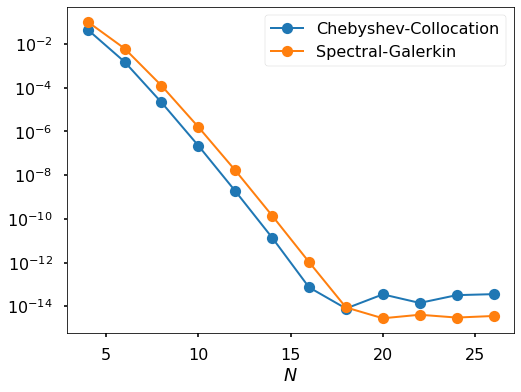

In [166]:
plt.figure(figsize = (8, 6))
plt.xlabel("$N$")
plt.semilogy(cells, err_cc, 'o-', lw=2, label='Chebyshev-Collocation')
plt.semilogy(cells, err_sg, 'o-', lw=2, label='Spectral-Galerkin')
plt.legend(loc='upper right')